In [168]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import random
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch import optim
from torch.autograd import Variable
from sklearn import preprocessing
plt.rc('font', size=12)
random.seed(0)

In [4]:
# read in the data file
dat = pd.read_csv('dataset/auto-mpg.csv', na_values = '?',)
dat = dat.drop(columns = ['car name'])
y = dat['mpg']
x = dat.drop(columns = ['mpg'])
origin = x.pop('origin')
x['USA'] = (origin == 1) * 1.0
x['Europe'] = (origin == 2) * 1.0
x['Japan'] = (origin == 3) * 1.0
x = x.dropna()
scaler = preprocessing.StandardScaler().fit(x)
x = scaler.transform(x)

ind = np.arange(x.shape[0])
random.shuffle(ind)
x = x[ind, :]
y = y[ind]

y_tensor = torch.tensor(y.values).float()
x_tensor = torch.tensor(x).float()

In [5]:
# create train / test split
n = len(y)
y_train = y_tensor[:300]
y_test = y_tensor[300:]
x_train = x_tensor[:300]
x_test = x_tensor[300:]

In [6]:
print(x_train.shape, x_test.shape)
print(x.shape)

torch.Size([300, 9]) torch.Size([92, 9])
(392, 9)


In [7]:
class MLP(nn.Module):
    """ Multilayer perceptron (MLP) with tanh/sigmoid activation functions implemented in PyTorch for regression tasks.

    Attributes:
        inputs (int): inputs of the network
        outputs (int): outputs of the network
        hidden_layers (list): layer structure of MLP: [5, 5] (2 hidden layer with 5 neurons)
        activation (string): activation function used ('relu', 'tanh' or 'sigmoid')

    """

    def __init__(self, inputs=1, outputs=1, hidden_layers=[100], activation='relu'):
        super(MLP, self).__init__()
        self.inputs = inputs
        self.outputs = outputs
        self.hidden_layers = hidden_layers
        self.nLayers = len(hidden_layers)
        self.net_structure = [inputs, *hidden_layers, outputs]
        
        if activation == 'relu':
            self.act = torch.relu
        elif activation == 'tanh':
            self.act = torch.tanh
        elif activation == 'sigmoid':
            self.act = torch.sigmoid
        else:
            assert('Use "relu","tanh" or "sigmoid" as activation.')
        # create linear layers y = Wx + b

        for i in range(self.nLayers + 1):
            setattr(self, 'layer_'+str(i), nn.Linear(self.net_structure[i], self.net_structure[i+1]))

    def forward(self, x):
        # connect layers
        for i in range(self.nLayers):
            layer = getattr(self, 'layer_'+str(i))
            x = self.act(layer(x))
        layer = getattr(self, 'layer_' + str(self.nLayers))
        x = layer(x)
        return x

In [8]:
class GaussianMLP(MLP):
    """ Gaussian MLP which outputs are mean and variance.

    Attributes:
        inputs (int): number of inputs
        outputs (int): number of outputs
        hidden_layers (list of ints): hidden layer sizes

    """

    def __init__(self, inputs=1, outputs=1, hidden_layers=[100], activation='relu'):
        super(GaussianMLP, self).__init__(inputs=inputs, outputs=2*outputs, hidden_layers=hidden_layers, activation=activation)
        self.outputs = outputs
    def forward(self, x):
        # connect layers
        for i in range(self.nLayers):
            layer = getattr(self, 'layer_'+str(i))
            x = self.act(layer(x))
        layer = getattr(self, 'layer_' + str(self.nLayers))
        x = layer(x)
        mean, variance = torch.split(x, self.outputs, dim=1)
        variance = torch.log(1 + torch.exp(variance))
        return mean, variance

In [9]:
def NLLloss(y, mean, var):
    """ Negative log-likelihood loss function. """
    return (torch.log(var) + torch.pow(y - mean, 2)/var).mean()

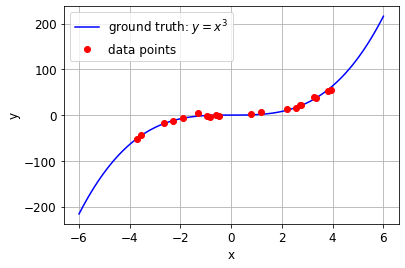

In [10]:
# try the toy example

def data_set(points=20, xrange=(-4, 4), std=3.):
    xx = torch.tensor([[np.random.uniform(*xrange)] for i in range(points)])
    yy = torch.tensor([[x**3 + np.random.normal(0, std)] for x in xx])
    return xx, yy

xx, yy = data_set(points=20, xrange=(-4, 4), std=3.) # generate data set of 20 samples
x = np.linspace(-6, 6, 100).reshape(100, 1)
y = x**3
plt.plot(x, y, 'b-', label='ground truth: $y=x^3$')
plt.plot(xx.numpy(),yy.numpy(),'or', label='data points')
plt.grid()
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

Loss at epoch  0 :  962.2288208007812
Loss at epoch  10 :  11.817480087280273
Loss at epoch  20 :  7.433032989501953
Loss at epoch  30 :  7.177590847015381
Loss at epoch  40 :  7.129239559173584
Loss at epoch  50 :  6.959173679351807
Loss at epoch  60 :  6.772106170654297
Loss at epoch  70 :  6.63167667388916
Loss at epoch  80 :  6.530454158782959
Loss at epoch  90 :  6.444911956787109
Loss at epoch  100 :  6.363184452056885
Loss at epoch  110 :  6.279199600219727
Loss at epoch  120 :  6.193889617919922
Loss at epoch  130 :  6.1076812744140625
Loss at epoch  140 :  6.02047061920166
Loss at epoch  150 :  5.931295871734619
Loss at epoch  160 :  5.841373443603516
Loss at epoch  170 :  5.750511646270752
Loss at epoch  180 :  5.658982753753662
Loss at epoch  190 :  5.567021369934082
Loss at epoch  200 :  5.474503993988037
Loss at epoch  210 :  5.381556034088135
Loss at epoch  220 :  5.288434028625488
Loss at epoch  230 :  5.19608211517334
Loss at epoch  240 :  5.104058742523193
Loss at epoc

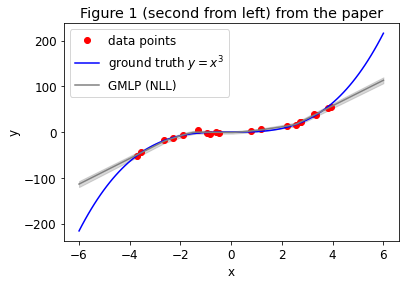

In [11]:
epochs = 1000
learning_rate = 0.01

gmlp = GaussianMLP(hidden_layers=[500], inputs = 1) 
gmlp_optimizer = torch.optim.Adam(params=gmlp.parameters(), lr=learning_rate)

for epoch in range(epochs):
    gmlp_optimizer.zero_grad()
    mean, var = gmlp(xx)
    gmlp_loss = NLLloss(yy, mean, var) #NLL loss
    if epoch  % 10 == 0:
        print('Loss at epoch ', epoch, ': ' ,gmlp_loss.item())
    gmlp_loss.backward()
    gmlp_optimizer.step()
print('final loss: ',gmlp_loss.item())
print(mean, var)

plt.plot(xx.numpy(),yy.numpy(),'or', label='data points')
plt.plot(x, y, 'b', label='ground truth $y=x^3$')
mean, var = gmlp(torch.tensor(x).float())
mean = mean.detach().numpy()
var = var.detach().numpy()
std = np.sqrt(var)
plt.plot(x, mean, 'grey', label='GMLP (NLL)')
plt.fill_between(x.reshape(100,), (mean-std).reshape(100,), (mean+std).reshape(100,),color='grey',alpha=0.3)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Figure 1 (second from left) from the paper')
plt.legend()

final loss:  2.043496608734131
final loss:  3.387463092803955
final loss:  3.214092254638672
final loss:  3.650611162185669
final loss:  3.4886348247528076
MAPE:  tensor(6.0903, grad_fn=<MeanBackward0>)
tensor([ 37.6176,  24.6272,  23.5398,  50.8972,   4.7345,  -0.7733, -48.4636,
         36.5935,   1.8708,  -0.6129, -13.0410,  -6.2686,  15.4455,  -0.6370,
         -0.8320, -21.0072,  20.2703,  48.6013,  -1.0516, -44.2847],
       grad_fn=<MeanBackward1>) tensor([[ 36.2937],
        [ 22.3540],
        [ 21.1762],
        [ 55.2673],
        [  6.1069],
        [ -3.3680],
        [-51.3047],
        [ 40.5022],
        [  2.8780],
        [ -0.9355],
        [-13.0011],
        [ -7.1878],
        [ 13.0850],
        [  0.3773],
        [ -2.8445],
        [-17.9313],
        [ 15.5199],
        [ 52.3876],
        [  4.2759],
        [-44.5022]])
tensor([0.1559, 0.3069, 0.5417, 0.2091, 0.9986, 0.9626, 0.9931, 0.3653, 1.0000,
        0.9946, 0.9524, 0.9595, 0.8456, 1.0000, 0.9999, 0.9

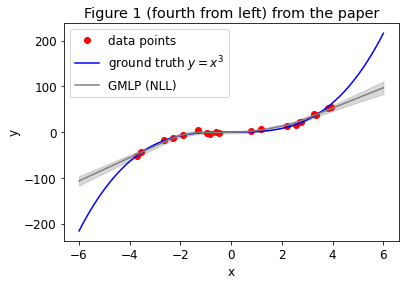

In [12]:
# train ensemble of 5 such models
n_model = 5
epochs = 1000
learning_rate = 0.01
model_ensemble = []

for i in range(n_model):
    gmlp = GaussianMLP(hidden_layers=[500], inputs = 1) 
    gmlp_optimizer = torch.optim.Adam(params=gmlp.parameters(), lr=learning_rate)
    
    for epoch in range(epochs):
        gmlp_optimizer.zero_grad()
        mean, var = gmlp(xx)
        gmlp_loss = NLLloss(yy, mean, var) #NLL loss
        gmlp_loss.backward()
        gmlp_optimizer.step()
    print('final loss: ',gmlp_loss.item())
    model_ensemble.append(gmlp)
    
mean_test = torch.empty((20, 0))
var_test = torch.empty((20, 0))
pcdf = torch.empty(20)

for i in range(n_model):
    output =  model_ensemble[i](xx)
    mean_test = torch.cat([mean_test, output[0]], dim = 1)
    var_test = torch.cat([var_test, output[1]], dim = 1)

mean_pred = mean_test.mean(axis = 1)
var_pred = torch.mean(var_test + mean_test.pow(2), axis = 1) - mean_pred.pow(2)

for i in range(20):
    m = torch.distributions.normal.Normal(mean_pred[i], var_pred[i], validate_args=None)
    pcdf[i] = m.cdf(y_test[i])

print('MAPE: ', torch.mean(torch.abs((mean_pred - yy) / yy)))
print(mean_pred, yy)
print(pcdf)

plt.plot(xx.numpy(),yy.numpy(),'or', label='data points')
plt.plot(x, y, 'b', label='ground truth $y=x^3$')

mean_test = torch.empty((100, 0))
var_test = torch.empty((100, 0))
pcdf = torch.empty(100)

for i in range(n_model):
    output =  model_ensemble[i](torch.tensor(x).float())
    mean_test = torch.cat([mean_test, output[0]], dim = 1)
    var_test = torch.cat([var_test, output[1]], dim = 1)

mean_pred = mean_test.mean(axis = 1)
var_pred = torch.mean(var_test + mean_test.pow(2), axis = 1) - mean_pred.pow(2)

mean = mean_pred.detach().numpy()
var = var_pred.detach().numpy()
std = np.sqrt(var)
plt.plot(x, mean, 'grey', label='GMLP (NLL)')
plt.fill_between(x.reshape(100,), (mean-std).reshape(100,), (mean+std).reshape(100,),color='grey',alpha=0.3)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Figure 1 (fourth from left) from the paper')
plt.legend()

GaussianMLP(
  (layer_0): Linear(in_features=9, out_features=100, bias=True)
  (layer_1): Linear(in_features=100, out_features=100, bias=True)
  (layer_2): Linear(in_features=100, out_features=2, bias=True)
)
Loss at epoch  0 :  602.614501953125
Loss at epoch  10 :  254.73544311523438
Loss at epoch  20 :  116.36005401611328
Loss at epoch  30 :  48.50899887084961
Loss at epoch  40 :  40.99325942993164
Loss at epoch  50 :  34.23647689819336
Loss at epoch  60 :  33.04243850708008
Loss at epoch  70 :  31.301008224487305
Loss at epoch  80 :  30.509981155395508
Loss at epoch  90 :  29.85577392578125
Loss at epoch  100 :  29.44374656677246
Loss at epoch  110 :  29.099870681762695
Loss at epoch  120 :  28.7905330657959
Loss at epoch  130 :  28.511764526367188
Loss at epoch  140 :  28.261192321777344
Loss at epoch  150 :  28.035396575927734
Loss at epoch  160 :  27.82875633239746
Loss at epoch  170 :  27.630237579345703
Loss at epoch  180 :  27.439498901367188
Loss at epoch  190 :  27.253576278

Loss at epoch  1950 :  2.9027912616729736
Loss at epoch  1960 :  2.6080517768859863
Loss at epoch  1970 :  2.485658884048462
Loss at epoch  1980 :  3.396364450454712
Loss at epoch  1990 :  2.8278884887695312
Loss at epoch  2000 :  2.4697301387786865
Loss at epoch  2010 :  2.483654260635376
Loss at epoch  2020 :  2.8595387935638428
Loss at epoch  2030 :  2.576239824295044
Loss at epoch  2040 :  2.372633457183838
Loss at epoch  2050 :  2.8316526412963867
Loss at epoch  2060 :  2.506103992462158
Loss at epoch  2070 :  2.2572901248931885
Loss at epoch  2080 :  2.8444628715515137
Loss at epoch  2090 :  2.560995578765869
Loss at epoch  2100 :  2.311228036880493
Loss at epoch  2110 :  2.792904853820801
Loss at epoch  2120 :  2.3762338161468506
Loss at epoch  2130 :  2.115534782409668
Loss at epoch  2140 :  2.4912357330322266
Loss at epoch  2150 :  2.2085180282592773
Loss at epoch  2160 :  3.2398579120635986
Loss at epoch  2170 :  2.306128740310669
Loss at epoch  2180 :  2.4174699783325195
Los

Loss at epoch  3910 :  0.7783747911453247
Loss at epoch  3920 :  0.5473700165748596
Loss at epoch  3930 :  1.0845831632614136
Loss at epoch  3940 :  0.6726270318031311
Loss at epoch  3950 :  0.49596938490867615
Loss at epoch  3960 :  0.767882764339447
Loss at epoch  3970 :  0.7774337530136108
Loss at epoch  3980 :  1.1560720205307007
Loss at epoch  3990 :  0.5295253992080688
final loss:  0.5582354068756104


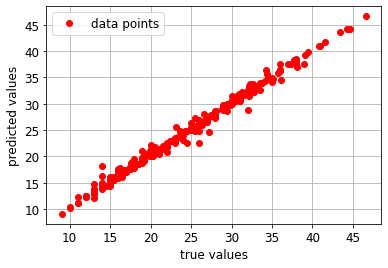

In [13]:
epochs = 4000
learning_rate = 0.005
n_train = 300
n_test = 98
mse = nn.MSELoss()

# train on the mpg dataset
gmlp = GaussianMLP(hidden_layers=[100, 100], inputs = 9, activation='relu') 
gmlp_optimizer = torch.optim.Adam(params=gmlp.parameters(), lr=learning_rate)
print(gmlp)

for epoch in range(epochs):
    gmlp_optimizer.zero_grad()
    mean, var = gmlp(x_train)
    gmlp_loss = mse(y_train.reshape(-1, 1), mean)
    if epoch  % 10 == 0:
        print('Loss at epoch ', epoch, ': ' ,gmlp_loss.item())
    gmlp_loss.backward()
    gmlp_optimizer.step()
print('final loss: ',gmlp_loss.item())

plt.plot(y_train.detach().numpy(), mean.squeeze(1).detach().numpy(), 'or', label='data points')
plt.grid()
plt.xlabel('true values')
plt.ylabel('predicted values')
plt.legend()
plt.show()

In [16]:
print('MAPE on test data using MSE loss: ', torch.mean(torch.abs((gmlp(x_test)[0].squeeze(1) - y_test) / y_test)))
print('MAPE on training data using MSE loss: ', torch.mean(torch.abs((gmlp(x_train)[0].squeeze(1) - y_train) / y_train)))

MAPE on test data using MSE loss:  tensor(0.3484, grad_fn=<MeanBackward0>)
MAPE on training data using MSE loss:  tensor(0.0249, grad_fn=<MeanBackward0>)


GaussianMLP(
  (layer_0): Linear(in_features=9, out_features=20, bias=True)
  (layer_1): Linear(in_features=20, out_features=20, bias=True)
  (layer_2): Linear(in_features=20, out_features=2, bias=True)
)
Loss at epoch  0 :  906.757080078125
MAPE on training data using NLLK loss:  tensor(1.0008, grad_fn=<MeanBackward0>)
MAPE on test data using NLLK loss:  tensor(1.0013, grad_fn=<MeanBackward0>)
Loss at epoch  100 :  7.54097318649292
MAPE on training data using NLLK loss:  tensor(0.2940, grad_fn=<MeanBackward0>)
MAPE on test data using NLLK loss:  tensor(0.2450, grad_fn=<MeanBackward0>)
Loss at epoch  200 :  5.54081392288208
MAPE on training data using NLLK loss:  tensor(0.2426, grad_fn=<MeanBackward0>)
MAPE on test data using NLLK loss:  tensor(0.2121, grad_fn=<MeanBackward0>)
Loss at epoch  300 :  4.98150110244751
MAPE on training data using NLLK loss:  tensor(0.2213, grad_fn=<MeanBackward0>)
MAPE on test data using NLLK loss:  tensor(0.2066, grad_fn=<MeanBackward0>)
Loss at epoch  40

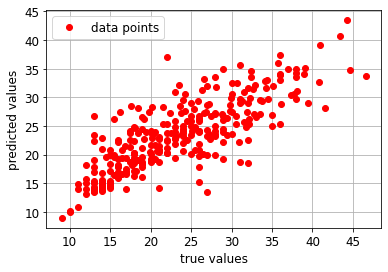

In [156]:
epochs = 2000
learning_rate = 0.003

# train on the mpg dataset
gmlp = GaussianMLP(hidden_layers=[20, 20], inputs = 9, activation='relu') 
gmlp_optimizer = torch.optim.RMSprop(params=gmlp.parameters(), lr=learning_rate)
print(gmlp)

for epoch in range(epochs):
    gmlp_optimizer.zero_grad()
    mean, var = gmlp(x_train)
    gmlp_loss = NLLloss(y_train, mean.squeeze(1), var.squeeze(1)) #NLL loss
    if epoch  % 100 == 0:
        print('Loss at epoch ', epoch, ': ' ,gmlp_loss.item())
        print('MAPE on training data using NLLK loss: ', torch.mean(torch.abs((gmlp(x_train)[0].squeeze(1) - y_train) / y_train)))
        print('MAPE on test data using NLLK loss: ', torch.mean(torch.abs((gmlp(x_test)[0].squeeze(1) - y_test) / y_test)))
    gmlp_loss.backward()
    gmlp_optimizer.step()
print('final loss: ',gmlp_loss.item())

plt.plot(y_train.detach().numpy(), mean.squeeze(1).detach().numpy(), 'or', label='data points')
plt.grid()
plt.xlabel('true values')
plt.ylabel('predicted values')
plt.legend()
plt.show()

In [157]:
print('MAPE on test data using NLLK loss: ', torch.mean(torch.abs((gmlp(x_test)[0].squeeze(1) - y_test) / y_test)))
print('MAPE on training data using NLLK loss: ', torch.mean(torch.abs((gmlp(x_train)[0].squeeze(1) - y_train) / y_train)))

MAPE on test data using NLLK loss:  tensor(0.1968, grad_fn=<MeanBackward0>)
MAPE on training data using NLLK loss:  tensor(0.1523, grad_fn=<MeanBackward0>)


In [159]:
# train ensemble of 5 such models
n_model = 5
epochs = 2000
learning_rate = 0.003
model_ensemble = []

for i in range(n_model):
    gmlp = GaussianMLP(hidden_layers=[20, 20], inputs = 9, activation='relu') 
    gmlp_optimizer = torch.optim.Adam(params=gmlp.parameters(), lr=learning_rate)
    
    for epoch in range(epochs):
        gmlp_optimizer.zero_grad()
        mean, var = gmlp(x_train)
        gmlp_loss = NLLloss(y_train, mean.squeeze(1), var.squeeze(1)) #NLL loss
        if epoch == 0:
            print('initial loss: ',gmlp_loss.item())
        gmlp_loss.backward()
        gmlp_optimizer.step()
    print('final loss: ',gmlp_loss.item())
    model_ensemble.append(gmlp)

initial loss:  852.404296875
final loss:  4.20931339263916
initial loss:  712.3025512695312
final loss:  4.2976298332214355
initial loss:  977.9012451171875
final loss:  4.2060112953186035
initial loss:  841.1673583984375
final loss:  4.307040214538574
initial loss:  736.146484375
final loss:  4.286887168884277


In [171]:
n_test = 92

mean_test = torch.empty((n_test,0))
var_test = torch.empty((n_test,0))
pcdf = torch.empty(n_test)

for i in range(n_model):
    output =  model_ensemble[i](x_test)
    mean_test = torch.cat([mean_test, output[0]], dim = 1)
    var_test = torch.cat([var_test, output[1]], dim = 1)

mean_pred = mean_test.mean(axis = 1)
var_pred = torch.mean(var_test + mean_test.pow(2), axis = 1) - mean_pred.pow(2)

for i in range(n_test):
    m = torch.distributions.normal.Normal(mean_pred[i], torch.sqrt(var_pred[i]), validate_args=None)
    pcdf[i] = m.cdf(y_test[i])

print('MAPE: ', torch.mean(torch.abs(mean_pred - y_test) / y_test))
print(pcdf)

MAPE:  tensor(0.1965, grad_fn=<MeanBackward0>)
tensor([0.1248, 0.3537, 0.7070, 0.9140, 0.9047, 0.1795, 0.8497, 0.6924, 0.5777,
        0.5115, 0.6077, 0.2034, 0.7793, 0.5621, 0.5954, 0.1356, 0.2716, 0.8230,
        0.4321, 0.4138, 0.5785, 0.2964, 0.6269, 0.3023, 0.3413, 0.3138, 0.5087,
        0.8680, 0.3305, 0.9392, 0.4117, 0.8952, 0.3258, 0.0988, 0.4665, 0.9244,
        0.0414, 0.0308, 0.3713, 0.1880, 0.7173, 0.7330, 0.8185, 0.3251, 0.9081,
        0.5184, 0.4248, 0.3096, 0.6812, 0.2620, 0.7529, 0.4288, 0.7447, 0.4390,
        0.2338, 0.8063, 0.9864, 0.1898, 0.2201, 0.9400, 0.8624, 0.1675, 0.1877,
        0.2903, 0.6901, 0.8638, 0.7908, 0.2351, 0.0795, 0.5860, 0.2654, 0.3764,
        0.0685, 0.0532, 0.1472, 0.2925, 0.8597, 0.8531, 0.4110, 0.2090, 0.1746,
        0.5726, 0.9877, 0.2654, 0.1530, 0.9991, 0.5772, 0.9221, 0.7792, 0.0094,
        0.0227, 0.9589], grad_fn=<CopySlices>)


In [172]:
from statsmodels.distributions.empirical_distribution import ECDF
ecdf = ECDF(y_test.detach().numpy())

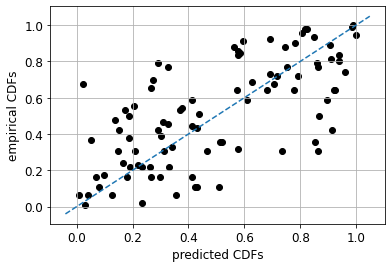

In [173]:
def abline(slope, intercept):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--')

fig, ax = plt.subplots()
ax.scatter(pcdf.detach().numpy(), ecdf(y_test.detach().numpy()), c='black')
abline(1, 0)
plt.grid()
plt.xlabel('predicted CDFs')
plt.ylabel('empirical CDFs')
plt.show()